In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path=os.getcwd()
print(path)

/content


*Check gpu configuration being assigned.*

In [4]:
!nvidia-smi

Sun May 11 17:57:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


# DATA **PREPARATION**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/plantdata.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantdata/val/Soybean___healthy/5ab639b3-7224-494c-923b-0b1a98a95c7b___RS_HL 5562 1.JPG  
  inflating: plantdata/val/Soybean___healthy/5b6bf5e0-ebef-4e36-9076-277c3570d939___RS_HL 3703.JPG  
  inflating: plantdata/val/Soybean___healthy/5bd50611-7796-43ce-85a1-9b83c266f1a8___RS_HL 6685.JPG  
  inflating: plantdata/val/Soybean___healthy/5c29dbf1-04c3-4bc7-a1a5-2dad3d7c27b6___RS_HL 6492.JPG  
  inflating: plantdata/val/Soybean___healthy/5c30906a-78f8-4b20-95c5-8cd67b1f9227___RS_HL 6100.JPG  
  inflating: plantdata/val/Soybean___healthy/5c6d8204-d0f7-43f7-a938-d6f1b6084fce___RS_HL 4156.JPG  
  inflating: plantdata/val/Soybean___healthy/5c737b7f-7b41-4b0b-aaaf-6db07c91cce5___RS_HL 5572.JPG  
  inflating: plantdata/val/Soybean___healthy/5c7a1342-2c8f-48ab-a575-1d3fe4ae6d03___RS_HL 6894.JPG  
  inflating: plantdata/val/Soybean___healthy/5cb24925-92d8-41f4-9c46-8bf7e8649b9d___RS_HL 7157.JPG  
  inflating: plantdata/val/Soybean___h

In [13]:
_LABELS = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry___healthy",
    "Cherry___Powdery_mildew",
    "Corn___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn___Common_rust",
    "Corn___healthy",
    "Corn___Northern_Leaf_Blight",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___healthy",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot",
    "Peach___healthy",
    "Pepper_bell___Bacterial_spot",
    "Pepper_bell___healthy",
    "Potato___Early_blight",
    "Potato___healthy",
    "Potato___Late_blight",
    "Raspberry___healthy",
    "Soybean___healthy",
    "Squash___Powdery_mildew",
    "Strawberry___healthy",
    "Strawberry___Leaf_scorch",
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
]


In [14]:
##YOU CAN USE THIS CELL IF YOU ARE RUNNING IT ON A LOCAL DEVICE
##HOWEVER IT DOES NOT DISTRIBUTE THIS UNBALANCED DATA EUALLY ACROSS CLASSES
##BETTER TO USE split-folders



# os.chdir('C:/Users/User/OneDrive/plant_dataset')
# if os.path.isdir('train/Apple___Apple_scab/') is False: #creates the following data structures if they don't exist previously
#     os.mkdir('train')
#     os.mkdir('valid')
#     os.mkdir('test')

#     for i in _LABELS:
#         shutil.move(f'{i}', 'train') # moves each class directory from our plant-village-dataset to train directory with the corresponding class
#         os.mkdir(f'valid/{i}') #creates the corresponding class directories(all 38 of them) in valid and test dirs
#         os.mkdir(f'test/{i}')

#         #this takes 30 samples from each class in train dirs and shifts them into the corresponding class dir in valid dir
#         valid_samples = random.sample(os.listdir(f'train/{i}'), 30) #returns filenames
#         for j in valid_samples:
#             shutil.move(f'train/{i}/{j}', f'valid/{i}')

#         # same as  done above in valid dir
#         test_samples = random.sample(os.listdir(f'train/{i}'), 5)
#         for k in test_samples:
#             shutil.move(f'train/{i}/{k}', f'test/{i}')
# os.chdir('../..')

In [15]:
path=os.getcwd()
print(path)

/content


In [18]:
train_path="/content/plantdata/train"
valid_path="/content/plantdata/val"
test_path="/content/plantdata/test"

In [19]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=16)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=16)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=16, shuffle=False)

Found 37997 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


# **MODEL BUILDING**

In [20]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [22]:
x = mobile.layers[-5].output
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = Dense(units=38, activation='softmax')(x)

*Not including the last 4 layers of the original MobileNet*

In [23]:
model = Model(inputs=mobile.input, outputs=output)
for layer in model.layers[:-22]:
    layer.trainable = False

*All layers from the 23rd-layer-from-last to the last year will be trained by this model.*

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,267,814 (12.47 MB)

 Trainable params: 1,901,606 (7.25 MB)

 Non-trainable params: 1,366,208 (5.21 MB)

# **TRAIN THE MODEL**

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=10,
            verbose=2
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2375/2375 - 108s - 45ms/step - accuracy: 0.9343 - loss: 0.2507 - val_accuracy: 0.9737 - val_loss: 0.0818
Epoch 2/10
2375/2375 - 86s - 36ms/step - accuracy: 0.9863 - loss: 0.0496 - val_accuracy: 0.9843 - val_loss: 0.0518
Epoch 3/10
2375/2375 - 88s - 37ms/step - accuracy: 0.9924 - loss: 0.0269 - val_accuracy: 0.9857 - val_loss: 0.0437
Epoch 4/10
2375/2375 - 83s - 35ms/step - accuracy: 0.9945 - loss: 0.0190 - val_accuracy: 0.9664 - val_loss: 0.1053
Epoch 5/10
2375/2375 - 82s - 35ms/step - accuracy: 0.9966 - loss: 0.0127 - val_accuracy: 0.9841 - val_loss: 0.0525
Epoch 6/10
2375/2375 - 146s - 62ms/step - accuracy: 0.9973 - loss: 0.0100 - val_accuracy: 0.9849 - val_loss: 0.0535
Epoch 7/10
2375/2375 - 140s - 59ms/step - accuracy: 0.9973 - loss: 0.0101 - val_accuracy: 0.9871 - val_loss: 0.0391
Epoch 8/10
2375/2375 - 142s - 60ms/step - accuracy: 0.9982 - loss: 0.0075 - val_accuracy: 0.9896 - val_loss: 0.0373
Epoch 9/10
2375/2375 - 141s - 59ms/step - accuracy: 0.9983 - loss: 0.0062 - val_accurac

# **PREDICT**

In [27]:
test_imgs, test_labels = next(test_batches)

In [28]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

# **PLOTTING PREDICTIONS WITH A CONFUSION MATRIX**

In [36]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(18, 14))  # Make the plot larger
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}" if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=8)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

In [38]:
test_batches.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry___Powdery_mildew': 5,
 'Cherry___healthy': 6,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn___Common_rust_': 8,
 'Corn___Northern_Leaf_Blight': 9,
 'Corn___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper_bell___Bacterial_spot': 18,
 'Pepper_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Tomato___Late_blight': 30,
 'Tomato___Leaf_Mold': 31,
 'Tomato___Septori

Confusion matrix, without normalization
[[ 62   0   0 ...   0   0   0]
 [  0  63   0 ...   0   0   0]
 [  0   0  28 ...   0   0   0]
 ...
 [  0   0   0 ... 535   0   0]
 [  0   0   0 ...   0  37   0]
 [  0   0   0 ...   0   0 160]]


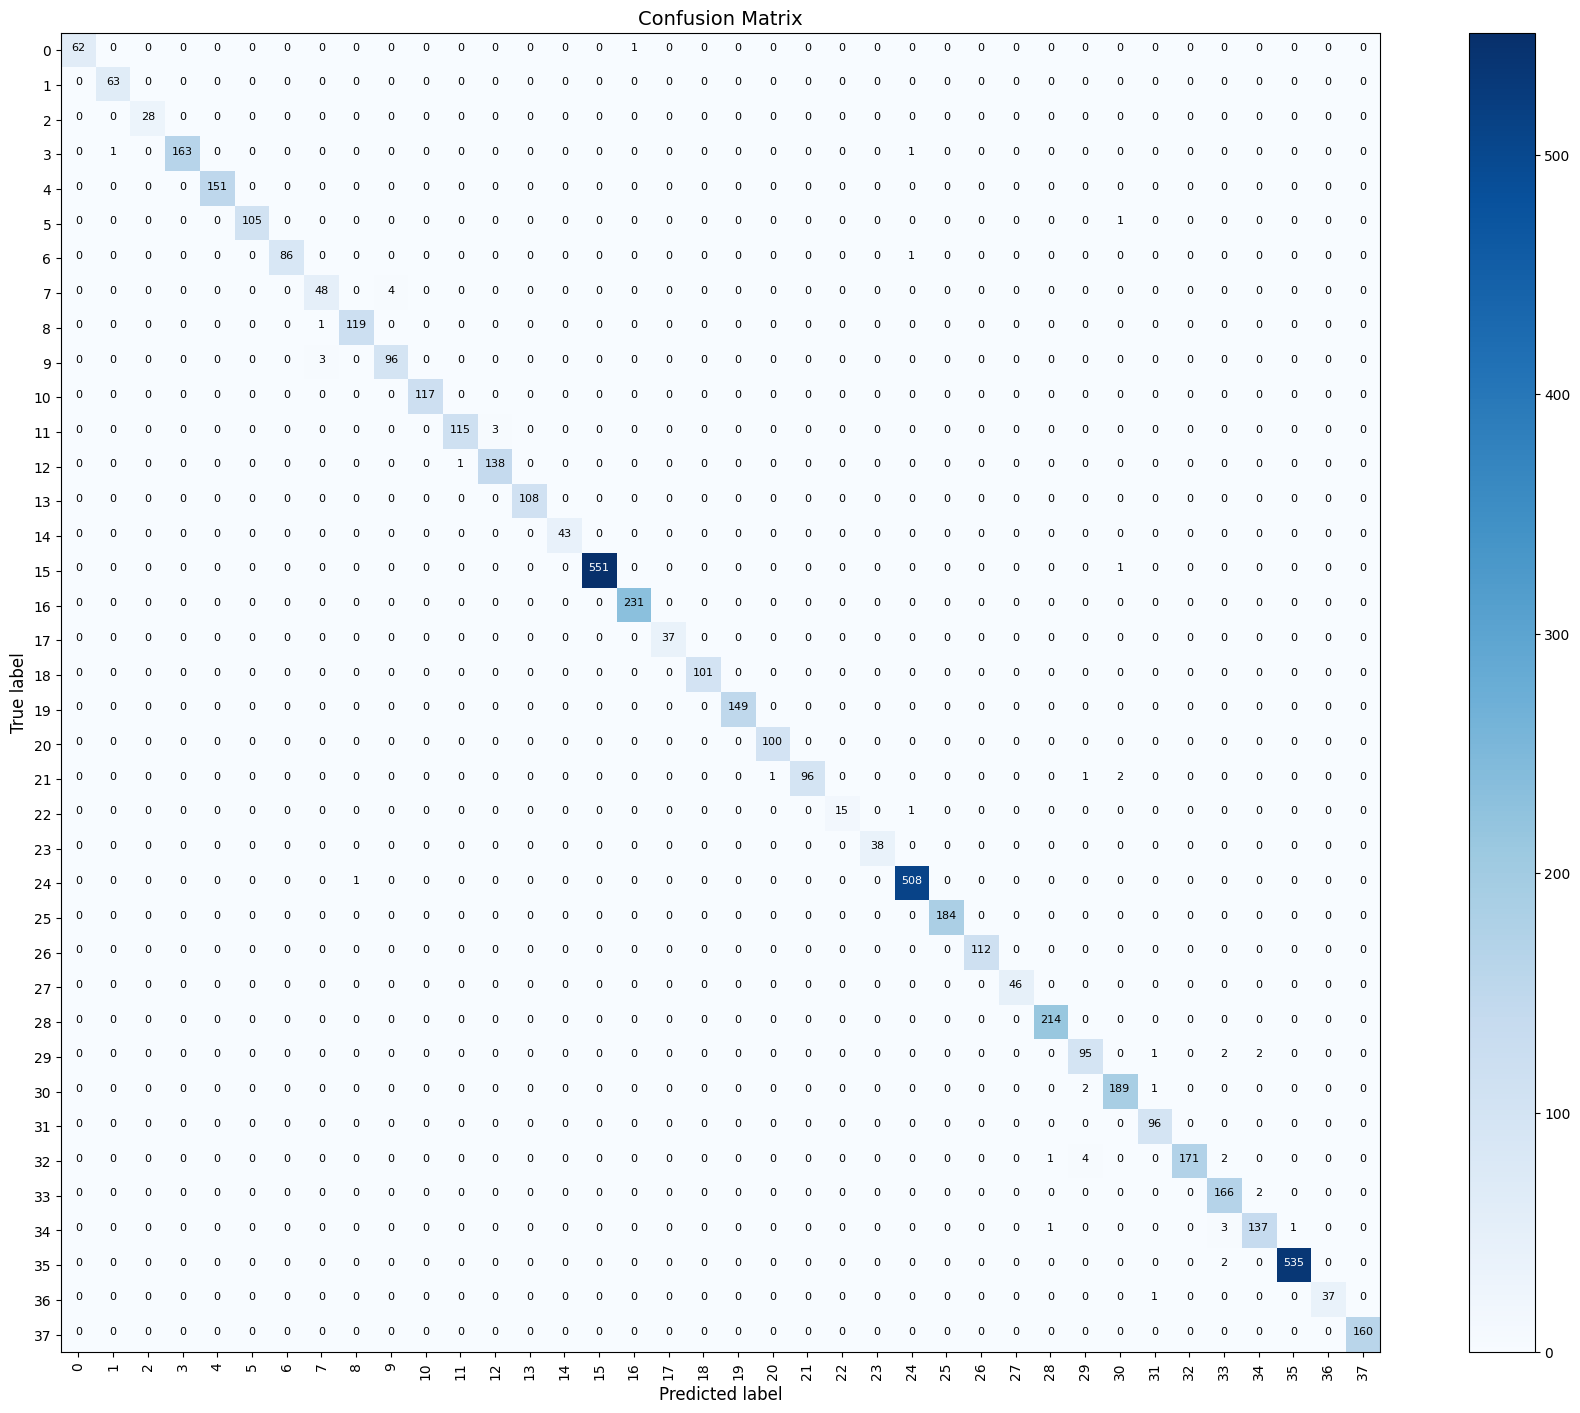

In [39]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# **Save the Model**

In [40]:
model.save('models/MobileNet.h5')

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model('models/MobileNet.h5')
new_model.summary()

*Saving and loading the weights of the model*

In [41]:
model.save_weights('models/MobileNetweights.weights.h5')

In [ ]:
model2 = Sequential([
    Dense(units=16, input_shape=(1,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2, activation='softmax')
])

model2.load_weights('models/MobileNetweights.weights.h5')

# **Predictions on unseen images using model**

In [43]:
def prepare_image(file):
    img_path = '/content/data'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

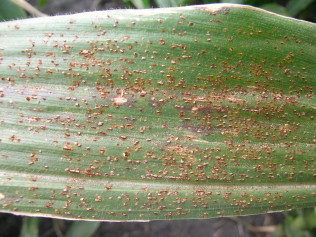

In [44]:
from IPython.display import Image
Image(filename='/content/data/corn_common_rust.jpeg', width=300,height=200)

In [49]:
preprocessed_image = prepare_image('/corn_common_rust.jpeg')
predictimg1 = model.predict(preprocessed_image)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [50]:
predicted_index = np.argmax(predictimg1)
predicted_label = _LABELS[predicted_index]

print(f"Predicted Class: {predicted_label}")

Predicted Class: Corn___Common_rust


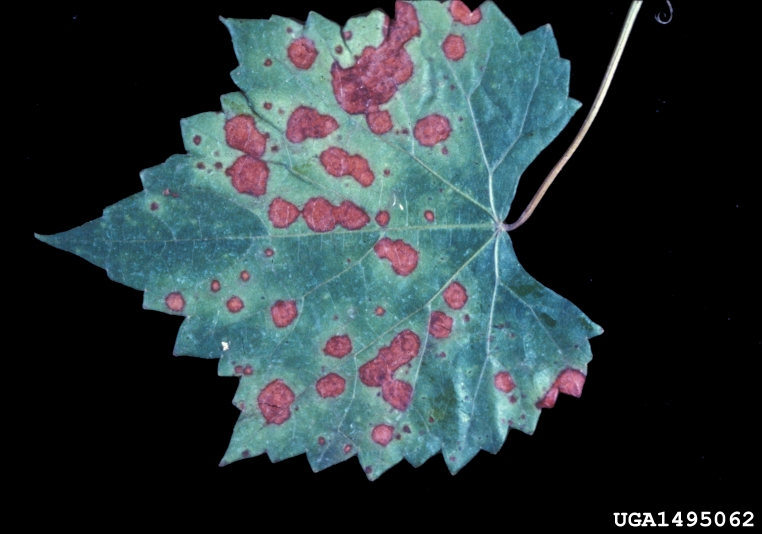

In [51]:
Image(filename='/content/data/grape_black_rot.jpg', width=300,height=200)

In [52]:
preprocessed_image2 = prepare_image('/grape_black_rot.jpg')
predictimg2 = model.predict(preprocessed_image2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [53]:
predicted_index = np.argmax(predictimg2)
predicted_label = _LABELS[predicted_index]

print(f"Predicted Class: {predicted_label}")

Predicted Class: Grape___Esca_(Black_Measles)
